In [55]:
"""
2023.04.05 可视化网络结构
参考链接：https://datawhalechina.github.io/thorough-pytorch/%E7%AC%AC%E4%B8%83%E7%AB%A0/7.1%20%E5%8F%AF%E8%A7%86%E5%8C%96%E7%BD%91%E7%BB%9C%E7%BB%93%E6%9E%84.html
"""
import torchvision
import os
import torchinfo
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

os.environ['TORCH_HOME'] = '../data/pretrain_weights'

# 7.1可视化网络结构

In [8]:
model = torchvision.models.resnet18()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
torchinfo.summary(model=model, input_size=(128, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 1000]               --
├─Conv2d: 1-1                            [128, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       128
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         128
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         128
│    │    └─ReLU: 3-6                    [128, 64, 56, 56]         --
│

# 7.2CNN可视化
https://datawhalechina.github.io/thorough-pytorch/%E7%AC%AC%E4%B8%83%E7%AB%A0/7.2%20CNN%E5%8D%B7%E7%A7%AF%E5%B1%82%E5%8F%AF%E8%A7%86%E5%8C%96.html

In [56]:
from pyparsing import Any

""" 定义Hook类. 运行需要的参数model,feats_in,feats_out """
class Hook(object):
    def __init__(self) -> None:
        self.model_name = []
        self.feats_in = []
        self.feats_out = []
    
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        print(f'hooker working', self)
        self.model_name.append(args[0].__class__)
        self.feats_in.append(args[1])
        self.feats_out.append(args[2])

In [64]:
def plot_feats(model, idx, input):
    """
    渲染特征图
    Args:
        model: 定义的模型
        idx: 模型的层索引
        input: 输入数据 B C H W
    """
    hh = Hook()
    model.features[idx].register_forward_hook(hh)   # 给模型的层注册Hook类，所以可以勾出此层的特征图

    # 进行前向推断, Hook捕获到注册层的特征图
    model.eval()
    model(input)
    print(f'{hh.model_name}\n{hh.feats_in[0][0].shape}\n{hh.feats_out[0].shape}')
    # 取出捕获的特征图
    out1 = hh.feats_out[0]  # 看来能同时给多个层注册Hook，输出结果是列表. out1.size B C H W
    total_ft = out1.shape[1]    # 对应维度C，本层输出特征图数量
    first_item = out1[0].cpu().clone()  # 拿出第1个样本的所有特征图。clone()，与源tensor不共享内存，具备梯度。(detach() 与源张量共享内存，不提供梯度)

    # 准备画图
    plt.figure(figsize=(10, 10))
    for idx in range(total_ft):     # 一共捕获total_ft张特征图
        if idx > 99:    # 只画100张
            break
        feature_map = first_item[idx]   # 形状：H W
        plt.subplot(10, 10, idx + 1)    # 第三个参数index从1开始
        plt.axis('off')
        plt.imshow(feature_map.detach().numpy())    # 参数要求是numpy

hooker working <__main__.Hook object at 0x0000018A4279D430>
[<class 'torch.nn.modules.conv.Conv2d'>]
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 112, 112])


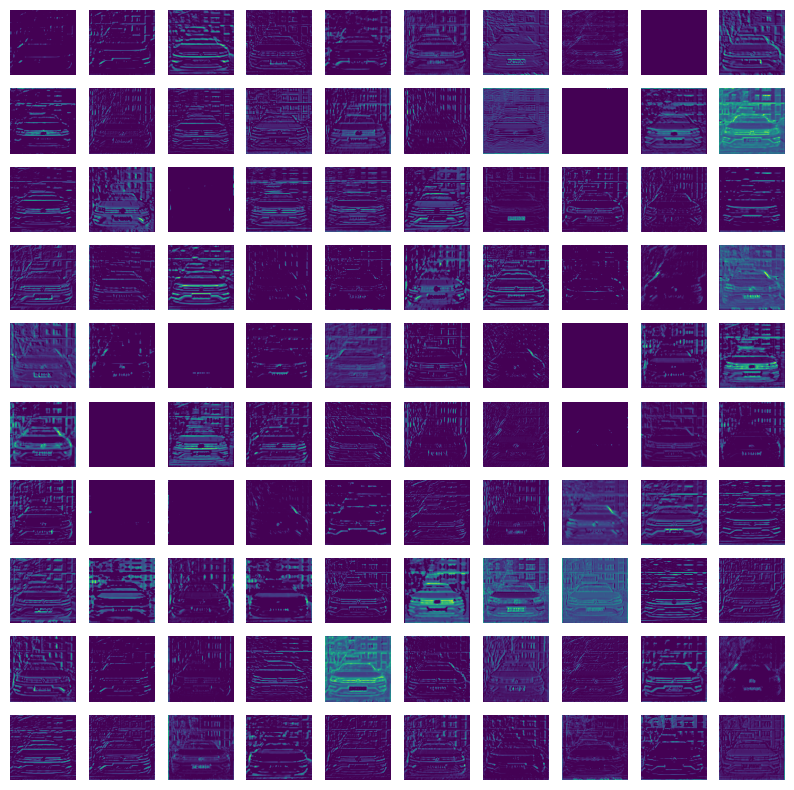

In [69]:
model = torchvision.models.vgg11(pretrained=True)

image = Image.open(r'D:\Projects\D2L\data\myperson\test\car\IMG_20221218_163814.jpg')
trans = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.CenterCrop([224, 224]),
    transforms.ToTensor()   # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
])
img_tensor = trans(image).unsqueeze(0)  # 得到B C H W

plot_feats(model, 3, img_tensor)

In [66]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=